Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 4.1) 타이타닉호의 생존자 가려내기

### 바로가기

- [<Step1. 탐색> : Titanic 데이터 살펴보기](#<Step1.-탐색>-:-Titanic-데이터-살펴보기)
    - [Titanic 데이터셋의 기본 정보]
    - [탐색적 데이터 분석]
- [<Step2. 분류> : 생존자 분류 모델 만들기](#<Step2.-분류>-:-생존자-분류-모델-만들기)
    - [분류 모델을 위한 전처리]
    - [분류 모델링]
- [<Step3. 모델 개선> : 피처 엔지니어링 첫걸음](#<Step3.-모델-개선>-:-피처-엔지니어링-첫걸음)
    - [피처에서 새로운 의미 추출해내기]
    - [피처 스케일링]
    - [피처 영향력 살펴보기]
- [<Step4. 평가> : 모델 검증하기](#<Step4.-평가>-:-모델-검증하기)
    - [K-fold 교차 검증 수행하기]
    - [학습 곡선 분석하기]

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색> : Titanic 데이터 살펴보기

### [Titanic 데이터셋의 기본 정보]

##### 데이터 피처 설명
- pclass : Passenger Class, 승객 등급
- survived : 생존 여부
- name : 승객 이름
- sex : 승객 성별
- age : 승객 나이
- sibsp : 탑승 한 형제/배우자 수
- parch : 탑승 한 부모/자녀 수
- ticket : 티켓 번호
- fare : 승객 지불 요금
- cabin : 선실 이름
- embarked : 승선항 (C = 쉘 부르그, Q = 퀸즈타운, S = 사우스 햄튼)
- body : 사망자 확인 번호
- home.dest : 고향/목적지

In [2]:
# Data Download : https://github.com/yoonkt200/python-data-analysis/tree/master/data

df_train = pd.read_csv("../data/titanic_train.csv")
df_test = pd.read_csv("../data/titanic_test.csv")
df_train.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [3]:
print(df_train.info())
print("-----------------")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
pclass       916 non-null int64
survived     916 non-null int64
name         916 non-null object
sex          916 non-null object
age          741 non-null float64
sibsp        916 non-null int64
parch        916 non-null int64
ticket       916 non-null object
fare         916 non-null float64
cabin        214 non-null object
embarked     914 non-null object
body         85 non-null float64
home.dest    527 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 93.1+ KB
None
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
pclass       393 non-null int64
survived     393 non-null int64
name         393 non-null object
sex          393 non-null object
age          305 non-null float64
sibsp        393 non-null int64
parch        393 non-null int64
ticket       393 non-null object
fare         393

##### 불필요한 피처 제거

In [4]:
df_train = df_train.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)
df_test = df_test.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)

-----

### [탐색적 데이터 분석]

0    563
1    353
Name: survived, dtype: int64


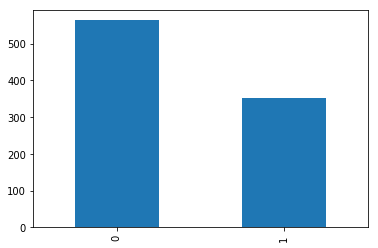

In [5]:
print(df_train['survived'].value_counts())
df_train['survived'].value_counts().plot.bar()

3    498
1    230
2    188
Name: pclass, dtype: int64


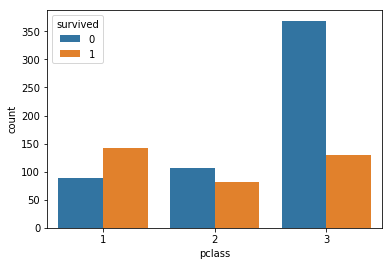

In [6]:
print(df_train['pclass'].value_counts())
ax = sns.countplot(x='pclass', hue = 'survived',  data = df_train)

In [7]:
# 반복 작업으로 평가해주는 변수 탐색작업을 자동화
from scipy import stats

def valid_features(df, col_name, distribution_check=True):
    # 두 집단의 분포 그래프 출력
    g = sns.FacetGrid(df, col='survived')
    g.map(plt.hist, col_name, bins=30)

    # 두 집단의 표준편차 출력
    titanic_survived = df[df['survived']==1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    print("data std is", '%.2f' % np.std(titanic_survived_static))
    titanic_n_survived = df[df['survived']==0]
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    print("data std is", '%.2f' % np.std(titanic_n_survived_static))
    
    # T-test로 평균의 차이 검정
    tTestResult = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name], equal_var=False)
    print("The t-statistic and p-value assuming equal variances is %.3f and %.3f." % tTestResult)
    print("The t-statistic and p-value not assuming equal variances is %.3f and %.3f" % tTestResultDiffVar)
    
    if distribution_check:
        # Shapiro-Wilk 검정 : 분포의 정규성 정도 검증
        print("The w-statistic and p-value in Survived %.3f and %.3f" % stats.shapiro(titanic_survived[col_name]))
        print("The w-statistic and p-value in Non-Survived %.3f and %.3f" % stats.shapiro(titanic_n_survived[col_name]))

data std is 14.22
data std is 13.71
The t-statistic and p-value assuming equal variances is -0.546 and 0.585.
The t-statistic and p-value not assuming equal variances is -0.543 and 0.587
The w-statistic and p-value in Survived 0.982 and 0.001
The w-statistic and p-value in Non-Survived 0.968 and 0.000


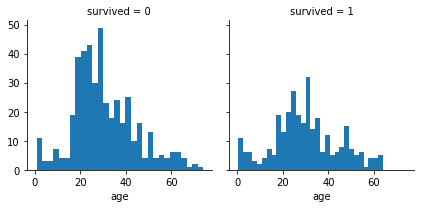

In [8]:
valid_features(df_train[df_train['age'] > 0], 'age', distribution_check=True)

data std is 0.64
data std is 1.34
The t-statistic and p-value assuming equal variances is -2.118 and 0.034.
The t-statistic and p-value not assuming equal variances is -2.446 and 0.015


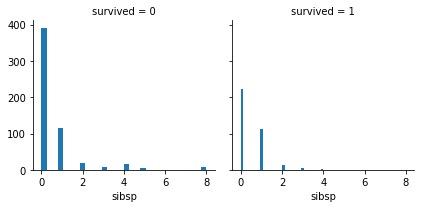

In [9]:
valid_features(df_train, 'sibsp', distribution_check=False)

-----

### `[미니 퀴즈 - 4.1]`
- `parch, fare, sex, embarked 피처에 대해 (생존자/비생존자) 간의 차이를 탐색해 보세요.` 
    - 위에서와 동일한 방법를 이용하여 생존자와 비생존자 그룹간의 평균과 분포가 어떻게 다른지, 혹은 통계적 유의성이 얼마나 있는지 대해 살펴보도록 합시다.
        - sex : 남/여에서 생존자와 비생존자간의 비율이 크게 다른것을 확인할 수 있습니다.
        - embarked : 3개의 승선항에 따라 생존자와 비생존자간의 비율이 부분적으로 다른것을 확인할 수 있습니다.
        - parch : 편차에 약간 차이가 있고, t-test 결과 두 집단의 평균에도 약간의 차이가 있다는 것을 알 수 있습니다.
        - fare : 편차에 많은 차이가 있고, t-test 결과 두 집단의 평균은 다르다고 확신할 수 있습니다.

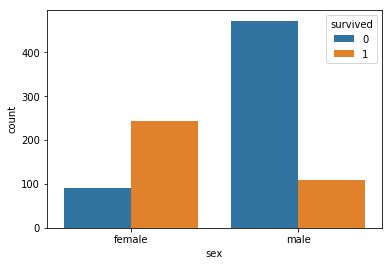

In [10]:
ax = sns.countplot(x='sex', hue = 'survived',  data = df_train)

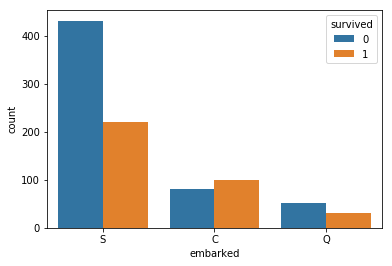

In [11]:
ax = sns.countplot(x='embarked', hue = 'survived',  data = df_train)

data std is 0.74
data std is 0.89
The t-statistic and p-value assuming equal variances is 1.865 and 0.063.
The t-statistic and p-value not assuming equal variances is 1.942 and 0.052


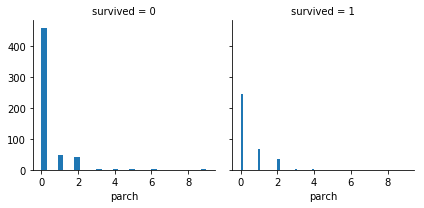

In [12]:
valid_features(df_train, 'parch', distribution_check=False)

data std is 60.68
data std is 33.65
The t-statistic and p-value assuming equal variances is 7.523 and 0.000.
The t-statistic and p-value not assuming equal variances is 6.657 and 0.000


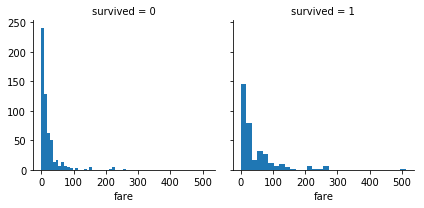

In [13]:
valid_features(df_train, 'fare', distribution_check=False)

-----

# <Step2. 분류> : 생존자 분류 모델 만들기

### [분류 모델을 위한 전처리]

In [14]:
# age의 결측값 보정 : 평균값으로 대체
replace_mean = df_train[df_train['age'] > 0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

# embark : 2개의 결측값은 최빈값으로 대체
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

# one-hot encoding을 위한 통합 데이터 프레임
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

# pandas 패키지를 이용한 one-hot 인코딩
whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

df_train.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,1,0,0,0,1
1,2,1,4.000000,1,1,23.0000,1,0,0,0,1
2,2,1,30.000000,1,0,13.8583,1,0,1,0,0
3,3,0,30.231444,0,0,7.7250,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,1,0,0,1,0


In [15]:
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

-----

### [분류 모델링]

##### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

accuracy: 0.80
Precision : 0.756
Recall : 0.673
F1 : 0.712


##### 분류 모델 평가

In [ ]:
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

-----

##### 분류 모델의 여러가지 평가 방법들
- Confusion Matrix 기반
    - Accuracy
    - Precision
    - Recall
    - F1 score
    - AUC (Area Under the Curve) & ROC (Receiver Operating Characteristic) curve

In [17]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[214  32]
 [ 48  99]]


-----

##### Logistic Regression model AUC

AUC : 0.837


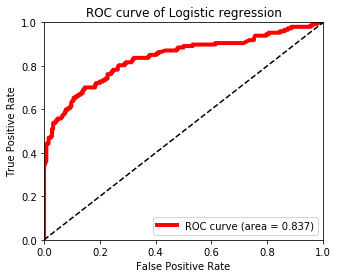

In [18]:
# AUC (Area Under the Curve) & ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve plot
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

-----

##### Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
y_pred_probability = dtc.predict_proba(x_test)[:,1]

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.76
Precision : 0.688
Recall : 0.646
F1 : 0.667


AUC : 0.744


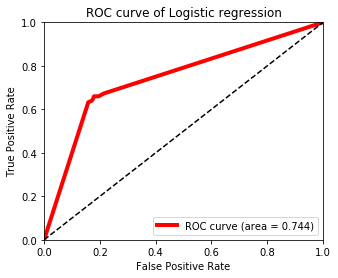

In [20]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve plot
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

-----

# <Step3. 모델 개선> : 피처 엔지니어링 첫걸음

### [피처에서 새로운 의미 추출해내기]

In [21]:
df_train = pd.read_csv("../data/titanic_train.csv")
df_test = pd.read_csv("../data/titanic_test.csv")
df_train = df_train.drop(['ticket', 'body', 'home.dest'], axis=1)
df_test = df_test.drop(['ticket', 'body', 'home.dest'], axis=1)

# age의 결측값 보정 : 평균값으로 대체
replace_mean = df_train[df_train['age'] > 0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

# embark : 2개의 결측값은 최빈값으로 대체
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

# one-hot encoding을 위한 통합 데이터 프레임
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

##### cabin 피처 활용하기

In [22]:
print(whole_df['cabin'].value_counts()[:10])

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
F4                 4
D                  4
F33                4
F2                 4
C78                4
B96 B98            4
C22 C26            4
Name: cabin, dtype: int64


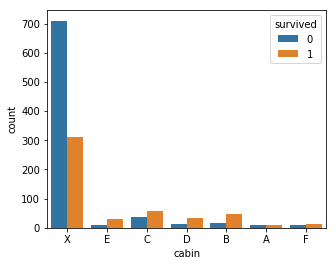

In [23]:
whole_df['cabin'] = whole_df['cabin'].fillna('X') # 결측 데이터의 경우
whole_df['cabin'] = whole_df['cabin'].apply(lambda x: x[0])
whole_df['cabin'] = whole_df['cabin'].replace({"G":"X", "T":"X"}) # G, T는 수가 너무 적기 때문에 X로 대체

ax = sns.countplot(x='cabin', hue = 'survived',  data = whole_df)
plt.show()

-----

##### name 피처 활용하기

In [24]:
# 이름에서 호칭 추출
name_grade = whole_df['name'].apply(lambda x : x.split(", ",1)[1].split(".")[0])
name_grade = name_grade.unique().tolist()
print(name_grade)

['Miss', 'Mr', 'Master', 'Mrs', 'Dr', 'Mlle', 'Col', 'Rev', 'Ms', 'Mme', 'Sir', 'the Countess', 'Dona', 'Jonkheer', 'Lady', 'Major', 'Don', 'Capt']


In [25]:
# 호칭에 따라 사회적 지위(1910년대 기준)를 정의
grade_dict = {'A': ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir'], # 명예직
              'B': ['Ms', 'Mme', 'Mrs', 'Dona'], # 여성
              'C': ['Jonkheer', 'the Countess'], # 귀족, 작위
              'D': ['Mr', 'Don'], # 남성
              'E': ['Master'], # 젊은남성
              'F': ['Miss', 'Mlle', 'Lady']} # 젊은 여성

def give_grade(x):
    grade = x.split(", ", 1)[1].split(".")[0]
    for key, value in grade_dict.items():
        for title in value:
            if grade == title:
                return key
    return 'G'
    
whole_df['name'] = whole_df['name'].apply(lambda x: give_grade(x))
print(whole_df['name'].value_counts())

D    758
F    263
B    201
E     61
A     24
C      2
Name: name, dtype: int64


------

### `[미니 퀴즈 - 4.2]`
- `‘cabin’ 피처와 마찬가지로, ‘name’ 피처에 대해 (생존자/비생존) 그룹 간의 차이를 탐색해 보세요.` 
    - 위와 동일한 방법을 이용하여 생존자와 비생존자 그룹간의 분포가 어떻게 다른지, 시각적으로 탐색해보도록 합시다.
        - 동일한 countplot으로 아래처럼 시각화가 가능합니다.
        - 두 그룹간의 '평균'값의 차이를 검정한 t-test와 같이, 두 그룹간의 '분포'의 차이를 검정하는 방법에는 '카이제곱 검정' 이라는 방법이 있습니다.
        - 카이제곱 검정의 실행 결과, p-value 0.000으로 두 그룹간의 분포가 통계적으로 유의미하게 다르다는 것을 알 수 있습니다.
            - `이에 대한 결과도 아래에 포함하였습니다.`

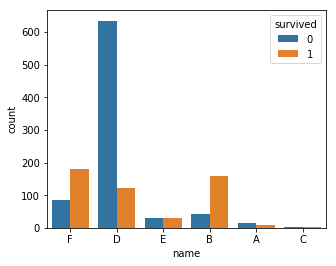

In [26]:
ax = sns.countplot(x='name', hue = 'survived',  data = whole_df)
plt.show()

In [27]:
from scipy import stats

chis = stats.chisquare(whole_df[whole_df['survived']==1]['cabin'].value_counts().sort_index(), 
                       whole_df[whole_df['survived']==0]['cabin'].value_counts().sort_index())
print("statistic = %.3f, pvalue = %.3f" % chis)

statistic = 341.971, pvalue = 0.000


-----

##### one-hot encoding

In [28]:
# pandas 패키지를 이용한 one-hot 인코딩
whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]
df_train.head()

,pclass,survived,age,sibsp,parch,fare,name_A,name_B,name_C,name_D,...,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_X,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,4.000000,1,1,23.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2,1,30.000000,1,0,13.8583,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,3,0,30.231444,0,0,7.7250,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


-----

##### 피처 엔지니어링이 완료된 데이터셋 학습

accuracy: 0.79
Precision : 0.736
Recall : 0.701
F1 : 0.718
AUC : 0.853


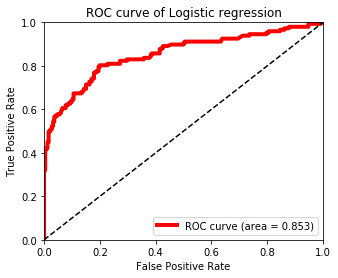

In [29]:
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))# AUC (Area Under the Curve) & ROC curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve plot
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

-----

### [피처 영향력 살펴보기]

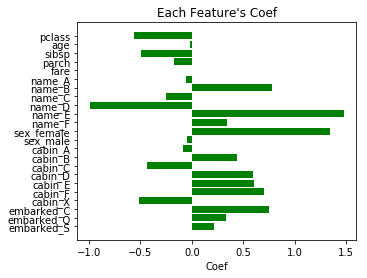

In [30]:
cols = df_train.columns.tolist()
cols.remove('survived')
y_pos = np.arange(len(cols))

plt.rcParams['figure.figsize'] = [5, 4]
fig, ax = plt.subplots()
ax.barh(y_pos, lr.coef_[0], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()
ax.set_xlabel('Coef')
ax.set_title("Each Feature's Coef")

plt.show()

-----

# <Step4. 평가> : 모델 검증하기

### [K-fold 교차 검증 수행하기]

- K-fold 교차 검증을 통한 과적합 검증

In [31]:
from sklearn.model_selection import KFold

k = 5
cv = KFold(k, shuffle=True, random_state=0)
auc_history = []
for i, (train_data_row, test_data_row) in enumerate(cv.split(whole_df_encoded)):
    df_train = whole_df_encoded.iloc[train_data_row]
    df_test = whole_df_encoded.iloc[test_data_row]
    
    splited_x_train, splited_y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
    splited_x_test, splited_y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values
    
    lr = LogisticRegression(random_state=0)
    lr.fit(splited_x_train, splited_y_train)
    y_pred = lr.predict(splited_x_test)
    y_pred_probability = lr.predict_proba(splited_x_test)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(splited_y_test, y_pred_probability)
    roc_auc = roc_auc_score(splited_y_test, y_pred_probability)
    auc_history.append(roc_auc)

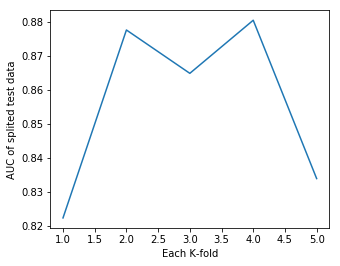

In [32]:
plt.xlabel("Each K-fold")
plt.ylabel("AUC of splited test data")
plt.plot(range(1, k+1), auc_history) # baseline

-----

### [학습 곡선 분석하기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지를 설치해 줍니다.
    - (env_name) $ `pip install scikit-plot`

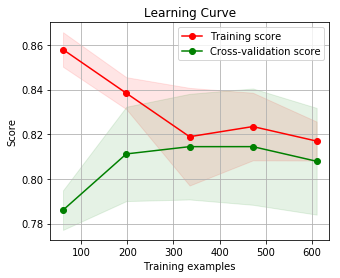

In [34]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(lr, x_train, y_train)
plt.show()